Emanuel Victor da Silva Favorato - 12558151

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

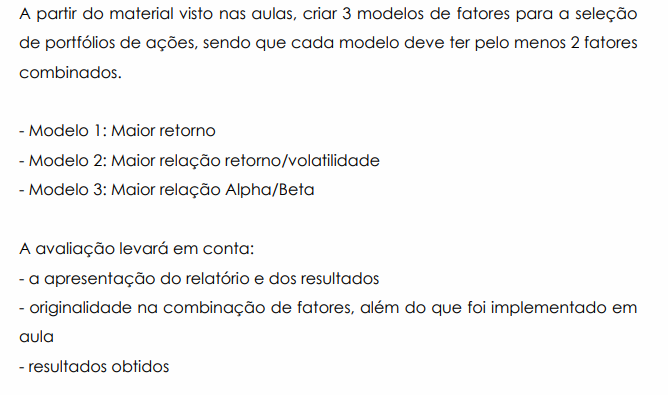

In [ ]:
# Data de início e fim do Back test
start='4/2000'
end='9/2024'

dados = pd.read_csv('Aula-DB-Acoes.csv', index_col=0)
indices_acc = pd.read_csv('Aula-DB-Indices.csv')
indices_acc.set_index('Data', inplace=True)
indices = indices_acc.pct_change(fill_method=None)

In [ ]:
dados

,Data,Empresa,Fechamento,Retorno,IBX,ROIC,ROE,PVP,Mom12,Mom6,Mom3,Volat,Pat_Liq
0,Apr-2000,ABEV3,0.279614,0.052049,0.310,1.485570,-6.519093,4.322196,NaN,NaN,8.903227,22.232147,1406790.0
1,Apr-2000,ABYA3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apr-2000,ACES3,9.095609,0.045871,0.028,-3.038846,-18.978114,0.616900,NaN,NaN,28.235296,61.446073,1445173.0
3,Apr-2000,ACES4,10.389367,0.126050,0.278,-3.038846,-18.978114,0.729999,NaN,NaN,5.309734,63.707985,1445173.0
4,Apr-2000,ACGU3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103401,Sep-2024,WEGE3,53.620000,-0.009788,3.364,23.593823,30.114952,9.157914,53.777720,48.582301,44.968323,30.782609,19299649.0
103402,Sep-2024,WEGE4,NaN,NaN,NaN,23.593823,30.114952,NaN,NaN,NaN,NaN,NaN,19299649.0
103403,Sep-2024,WHMT3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103404,Sep-2024,WIZC3,6.100000,-0.011345,NaN,19.710845,23.623256,1.663025,8.069882,2.849115,3.697479,38.278294,549042.0


## Buscando encontrar as melhores combinações de 2 ou mais fatores para a seleção dos modelos.

In [ ]:
# Função auxiliar para calcular diferença de anos entre duas datas
def calc_dif_dates(start, end):
  data_dif = relativedelta(datetime.strptime(end, '%m/%Y'), datetime.strptime(start, '%m/%Y'))
  return data_dif.years + data_dif.months/12 # Função para avaliar o desempenho de uma carteira baseada em fatores

def evaluate_portfolio(dados, referencia, start, end, fatores, ascending_flags, filtro_fim=10):
    cost_trans = 0.0006  # custo de transação
    list_date, list_ret = [], []

    # Loop por cada mês no período
    for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):
        # Filtra os dados do mês específico com dados válidos
        cart = dados.loc[
            (dados['Data'] == dt) &
            (dados['IBX'] > 0) &
            (~dados['Retorno'].isnull())
        ].copy()

        # Aplica ranking para cada fator (ordenação crescente ou decrescente)
        for i, fator in enumerate(fatores):
            cart[f'rank_{i}'] = cart[fator].rank(ascending=ascending_flags[i])

        # Soma dos rankings e ranking final
        cart['rank_sum'] = cart[[f'rank_{i}' for i in range(len(fatores))]].sum(axis=1)
        cart['rank_final'] = cart['rank_sum'].rank(ascending=True)

        # Retorno médio da carteira selecionada, descontando custo de transação
        ret = cart.loc[cart['rank_final'] < filtro_fim, 'Retorno'].mean() - cost_trans
        list_date.append(dt)
        list_ret.append(ret)

    # Criação do DataFrame com os retornos mensais
    Port = pd.DataFrame({'Data': list_date, 'Ret': list_ret})
    Port.set_index('Data', inplace=True)

    # Cálculo do retorno acumulado e drawdown
    Port['Ret_acc'] = (1 + Port['Ret']).cumprod() - 1
    Port['acc_max'] = Port['Ret_acc'].cummax()
    Port['drawdown'] = ((1 + Port['Ret_acc']) / (1 + Port['acc_max'])) - 1

    # Métricas da carteira
    ret_acc = Port['Ret_acc'].iloc[-1] * 100  # Retorno acumulado (%)
    vol_aa = Port['Ret'].std() * np.sqrt(12) * 100  # Volatilidade anualizada
    drawdown = Port['drawdown'].min() * 100  # Máximo drawdown

    # Benchmark (referência) – retorno, volatilidade, acumulado
    Port['Ref'] = referencia
    Port['Ref_acc'] = (1 + Port['Ref']).cumprod() - 1
    ret_ref_acc = Port['Ref_acc'].iloc[-1] * 100
    vol_ref_aa = Port['Ref'].std() * np.sqrt(12) * 100

    # Regressão OLS para Alpha e Beta em relação ao benchmark
    model = sm.OLS(Port['Ret'].values, sm.add_constant(Port['Ref'].values), missing='drop').fit()
    alpha = model.params[0] * 12 * 100  # Alpha anualizado (%)
    beta = model.params[1]  # Beta da carteira

    # Retorno anualizado
    ret_anual = (pow(ret_acc / 100 + 1, 1 / calc_dif_dates(start, end)) - 1) * 100

    # Índice tipo Sharpe (sem taxa livre de risco)
    sharpe_like = ret_anual / vol_aa if vol_aa != 0 else np.nan

    # Relação alpha/beta
    alpha_beta_ratio = alpha / beta if beta != 0 else np.nan

    # Retorna um dicionário com as métricas do portfólio
    return {
        'fatores': fatores,
        'ret_acc': ret_acc,
        'ret_anual': ret_anual,
        'vol_aa': vol_aa,
        'drawdown': drawdown,
        'sharpe_like': sharpe_like,
        'alpha': alpha,
        'beta': beta,
        'alpha_beta_ratio': alpha_beta_ratio
    }

# Função para rodar todas as combinações possíveis de fatores (de 2 até N fatores)
def run_all_combinations(dados, referencia, start, end, fator_list, filtro_fim=10):
    results = []
    print("🔄 Processando combinações...")

    # Combinações de 2 até N fatores
    for r in range(2, len(fator_list) + 1):
        for combo in tqdm(itertools.combinations(fator_list, r), desc=f"{r} fatores"):
            # Define a ordem de ranking para cada fator
            # Crescente para fatores como Volatilidade ou P/VPA, decrescente para outros
            ascending_flags = [True if f in ['Volat', 'PVP'] else False for f in combo]

            # Avalia a performance da carteira baseada na combinação
            result = evaluate_portfolio(dados, referencia, start, end, list(combo), ascending_flags, filtro_fim)
            results.append(result)

    # Converte os resultados para DataFrame
    df_results = pd.DataFrame(results)

    # Imprime os melhores modelos segundo 3 critérios diferentes
    print("\n🏆 MELHORES PORTFÓLIOS:")
    print("Modelo 1 - Maior Retorno Acumulado:")
    print(df_results.loc[df_results['ret_acc'].idxmax()][['fatores', 'ret_acc']])

    print("\nModelo 2 - Maior Retorno / Volatilidade (Sharpe-like):")
    print(df_results.loc[df_results['sharpe_like'].idxmax()][['fatores', 'sharpe_like']])

    print("\nModelo 3 - Maior Alpha / Beta:")
    print(df_results.loc[df_results['alpha_beta_ratio'].idxmax()][['fatores', 'alpha_beta_ratio']])

    return df_results

# =========================
# 🚀 EXECUÇÃO DO CÓDIGO
# =========================

# Lista de fatores disponíveis
fatores = ['ROIC', 'ROE', 'Mom12', 'Mom6', 'Mom3', 'Volat', 'PVP', 'Pat_Liq']

# Chamada da função para rodar todas as combinações de fatores
df_resultados = run_all_combinations(
    dados=dados,                 # DataFrame com os dados dos ativos
    referencia= indices['IBOV'],           # Série com retornos mensais do benchmark (IBX)
    # Data de início e fim do Back test
    start='4/2000',
    end='9/2024',               # Fim do período
    fator_list=fatores,             # Lista dos fatores a testar
    filtro_fim=10                   # Número de ativos a selecionar por mês (top-N)
)

🔄 Processando combinações...


2 fatores: 0it [00:00, ?it/s]<ipython-input-14-740151574e73>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):
2 fatores: 1it [00:04,  4.37s/it]<ipython-input-14-740151574e73>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):
2 fatores: 2it [00:08,  3.96s/it]<ipython-input-14-740151574e73>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):
2 fatores: 3it [00:11,  3.91s/it]<ipython-input-14-740151574e73>:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):
2 fatores: 4it [00:16,  


🏆 MELHORES PORTFÓLIOS:
Modelo 1 - Maior Retorno Acumulado:
fatores    [Mom12, Mom6, Mom3, PVP]
ret_acc                42877.626347
Name: 140, dtype: object

Modelo 2 - Maior Retorno / Volatilidade (Sharpe-like):
fatores        [Mom6, Volat, PVP]
sharpe_like              1.141756
Name: 77, dtype: object

Modelo 3 - Maior Alpha / Beta:
fatores             [Mom12, Mom6, Volat, PVP]
alpha_beta_ratio                    27.409856
Name: 142, dtype: object


In [ ]:
# Implementando os modelos

def create_port_3_fatores_par(fator1, ascending1, fator2, ascending2, fator3, ascending3, filtro_fim, dados, referencia):

  cost_trans = 0.0006

  list_date = []
  list_ret = []

  for dt in pd.date_range(start=start, end=end, freq='ME').strftime('%b-%Y'):
    cart = dados.loc[(dados['Data']==dt) & (dados['IBX'] > 0) & (dados['Retorno'].isnull() == False)].copy()

    cart['rank1'] = cart[fator1].rank(ascending=ascending1)
    cart['rank2'] = cart[fator2].rank(ascending=ascending2)
    cart['rank3'] = cart[fator3].rank(ascending=ascending3)
    cart['rank_sum'] = cart['rank1']+cart['rank2']

    cart['rank4'] = cart['rank_sum'].rank(ascending=True)

    ret = cart.loc[(cart['rank4'] < filtro_fim)]['Retorno'].mean()  - cost_trans

    list_date.append(dt)
    list_ret.append(ret)

  dic = {'Data': list_date,
        'Ret': list_ret}

  # Cria um dataframe com data e retornos mensais
  Port1 = pd.DataFrame(dic)
  Port1.set_index('Data', inplace=True)
  Port1['Ret_acc'] = (1+Port1['Ret']).cumprod()-1 #Calcula os retornos acumulados

  #Calcula o drawdown
  Port1['acc_max']=Port1['Ret_acc'].cummax()
  Port1['drawdown']=((1+Port1['Ret_acc'])/(1+Port1['acc_max']))-1
  drawdown = Port1['drawdown'].min()*100

  #Calcula retorno acumulado e volatilidade anualizada
  ret_acc = Port1['Ret_acc'].iloc[-1]*100
  vol_aa = Port1['Ret'].std()*(12**(1/2))*100

  #Seleciona referência e calcula retorno acumulado
  Port1['Ref']=referencia
  Port1['Ref_acc'] = (1+Port1['Ref']).cumprod()-1

  ret_ref_acc = Port1['Ref_acc'].iloc[-1]*100
  vol_ref_aa = Port1['Ref'].std()*(12**(1/2))*100

  print('Portfolio [', fator1, fator2, filtro_fim, '] \nRet Acc:', round(ret_acc, 2), '%  Ret anual.:', round((pow(ret_acc/100+1, 1/calc_dif_dates(start, end))-1)*100, 2), '%  Vol anual.:', round(vol_aa, 2), '% Drawdown:', round(drawdown, 2), '%')
  print('\nReferência \nRet Acc:', round(ret_ref_acc, 2), '%  Ret anual.:', round((pow(ret_ref_acc/100+1, 1/calc_dif_dates(start, end))-1)*100, 2), '%  Vol anual.:', round(vol_ref_aa, 2), '%')

  #Calcula o Alpha e o Beta do portfólio
  model = sm.OLS(Port1['Ret'].to_list(), sm.add_constant(Port1['Ref'].to_list()), missing='drop').fit()
  print("\nPort Alpha:",round(model.params[0]*(12)*100,2),"% Beta:", round(model.params[1],2), " / P-values:", round(model.pvalues[0],3), round(model.pvalues[1],3), "\n")

  return Port1.copy()

def create_port_4_fatores_par(fator1, ascending1,
                               fator2, ascending2,
                               fator3, ascending3,
                               fator4, ascending4,
                               filtro_fim, dados, referencia):

    cost_trans = 0.0006
    list_date = []
    list_ret = []

    for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):
        cart = dados.loc[
            (dados['Data'] == dt) &
            (dados['IBX'] > 0) &
            (dados['Retorno'].notnull())
        ].copy()

        # Rankeia os fatores
        cart['rank1'] = cart[fator1].rank(ascending=ascending1)
        cart['rank2'] = cart[fator2].rank(ascending=ascending2)
        cart['rank3'] = cart[fator3].rank(ascending=ascending3)
        cart['rank4'] = cart[fator4].rank(ascending=ascending4)

        # Soma dos ranks
        cart['rank_sum'] = cart['rank1'] + cart['rank2'] + cart['rank3'] + cart['rank4']
        cart['rank_final'] = cart['rank_sum'].rank(ascending=True)

        # Retorno médio dos melhores ativos
        ret = cart.loc[cart['rank_final'] < filtro_fim, 'Retorno'].mean() - cost_trans

        list_date.append(dt)
        list_ret.append(ret)

    # Monta DataFrame com os resultados mensais
    Port1 = pd.DataFrame({'Data': list_date, 'Ret': list_ret})
    Port1.set_index('Data', inplace=True)

    Port1['Ret_acc'] = (1 + Port1['Ret']).cumprod() - 1

    # Drawdown
    Port1['acc_max'] = Port1['Ret_acc'].cummax()
    Port1['drawdown'] = ((1 + Port1['Ret_acc']) / (1 + Port1['acc_max'])) - 1
    drawdown = Port1['drawdown'].min() * 100

    # Métricas do portfólio
    ret_acc = Port1['Ret_acc'].iloc[-1] * 100
    vol_aa = Port1['Ret'].std() * np.sqrt(12) * 100

    # Referência
    Port1['Ref'] = referencia
    Port1['Ref_acc'] = (1 + Port1['Ref']).cumprod() - 1
    ret_ref_acc = Port1['Ref_acc'].iloc[-1] * 100
    vol_ref_aa = Port1['Ref'].std() * np.sqrt(12) * 100

    # Impressão dos resultados
    print('Portfolio [', fator1, fator2, fator3, fator4, '| filtro:', filtro_fim, ']')
    print('Ret Acumulado:', round(ret_acc, 2), '%',
          'Ret. Anualizado:', round((pow(ret_acc / 100 + 1, 1 / calc_dif_dates(start, end)) - 1) * 100, 2), '%',
          'Vol. Anualizada:', round(vol_aa, 2), '%',
          'Drawdown:', round(drawdown, 2), '%')

    print('\nReferência:')
    print('Ret Acumulado:', round(ret_ref_acc, 2), '%',
          'Ret. Anualizado:', round((pow(ret_ref_acc / 100 + 1, 1 / calc_dif_dates(start, end)) - 1) * 100, 2), '%',
          'Vol. Anualizada:', round(vol_ref_aa, 2), '%')

    # Alpha e Beta
    model = sm.OLS(Port1['Ret'].values, sm.add_constant(Port1['Ref'].values), missing='drop').fit()
    alpha = model.params[0] * 12 * 100
    beta = model.params[1]
    pvals = model.pvalues

    print("\nPort Alpha:", round(alpha, 2), "% Beta:", round(beta, 2),
          " / P-values:", round(pvals[0], 3), round(pvals[1], 3), "\n")

    return Port1.copy()

In [ ]:
#fator = 'ROIC', 'ROE', 'Mom12', 'Mom6', 'Mom3', 'Volat', 'PVP', 'Pat_Liq'
#filtro_ini / filtro_fim = seleção de ações de acordo com o ranking
#ascending = 'True' para quanto menor melhor, 'False' para quanto maior melhor
#referencia = escolha do índice de referência dentro do dataframe indices. Ex: indices['IBOV'], indices['SP500BR'], indices['IPCA']

Port1 = create_port_4_fatores_par( 'Mom12', False, 'Mom6', False, 'Mom3', False, 'PVP', True, 10, dados=dados, referencia=indices['IBOV'])

Port2 = create_port_3_fatores_par( 'Mom6', False, 'Volat', True, 'PVP', True, 10, dados=dados, referencia=indices['IBOV'])

Port3 = create_port_4_fatores_par( 'Mom12', False, 'Mom6', False, 'Volat', True, 'PVP', True, 10, dados=dados, referencia=indices['IBOV'])

<ipython-input-12-f9f0d92018f9>:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):


Portfolio [ Mom12 Mom6 Mom3 PVP | filtro: 10 ]
Ret Acumulado: 17822.8 % Ret. Anualizado: 23.68 % Vol. Anualizada: 26.05 % Drawdown: -43.54 %

Referência:
Ret Acumulado: 663.21 % Ret. Anualizado: 8.68 % Vol. Anualizada: 24.22 %

Port Alpha: 15.94 % Beta: 0.79  / P-values: 0.0 0.0 

Portfolio [ Mom6 Volat 10 ] 
Ret Acc: 9624.71 %  Ret anual.: 20.62 %  Vol anual.: 18.93 % Drawdown: -27.82 %

Referência 
Ret Acc: 663.21 %  Ret anual.: 8.68 %  Vol anual.: 24.22 %

Port Alpha: 14.37 % Beta: 0.56  / P-values: 0.0 0.0 



<ipython-input-12-f9f0d92018f9>:66: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  for dt in pd.date_range(start=start, end=end, freq='M').strftime('%b-%Y'):


Portfolio [ Mom12 Mom6 Volat PVP | filtro: 10 ]
Ret Acumulado: 27973.77 % Ret. Anualizado: 25.97 % Vol. Anualizada: 21.7 % Drawdown: -31.32 %

Referência:
Ret Acumulado: 663.21 % Ret. Anualizado: 8.68 % Vol. Anualizada: 24.22 %

Port Alpha: 18.49 % Beta: 0.65  / P-values: 0.0 0.0 



Por alguma razão, os resultados dos três portifólios divergem na seleção e na implementação, após implementados, observamos que o portifólio 3 é o que possui maior retorno total, superando o portifólio 1, em torno de 28000%, além da maior razão alpha/beta (em torno de 28.45), o que era esperado durante o processo de seleção. Também possui maior retorno/volatilidade, superando o portifólio 2 (calculado em 1.197), considerado, inicialmente, como o que maximizava esta relação.

Entretanto, para a análise comparativa, serão considerados os desempenhos dos três portifólios.

# Resultados

In [ ]:
#Cria dataframe com resultados acumulados
Port1_acc = pd.DataFrame(Port1['Ret_acc'])
Port1_acc.rename(columns={"Ret_acc": "Port1"}, inplace=True)

Port1_ret_men = pd.DataFrame(Port1['Ret'])
Port1_ret_men.rename(columns={"Ret": "Port1"}, inplace=True)

Port1_ret_men['Referencia']=Port1['Ref']
Port1_acc['Referencia'] = Port1['Ref_acc']

Port2_acc = pd.DataFrame(Port2['Ret_acc'])
Port2_acc.rename(columns={"Ret_acc": "Port2"}, inplace=True)

Port2_ret_men = pd.DataFrame(Port2['Ret'])
Port2_ret_men.rename(columns={"Ret": "Port2"}, inplace=True)

Port2_ret_men['Referencia']=Port2['Ref']
Port2_acc['Referencia'] = Port2['Ref_acc']

Port3_acc = pd.DataFrame(Port3['Ret_acc'])
Port3_acc.rename(columns={"Ret_acc": "Port3"}, inplace=True)

Port3_ret_men = pd.DataFrame(Port3['Ret'])
Port3_ret_men.rename(columns={"Ret": "Port3"}, inplace=True)

Port3_ret_men['Referencia']=Port3['Ref']
Port3_acc['Referencia'] = Port3['Ref_acc']

<ipython-input-15-6ab0c17ee4ea>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
<ipython-input-15-6ab0c17ee4ea>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
<ipython-input-15-6ab0c17ee4ea>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


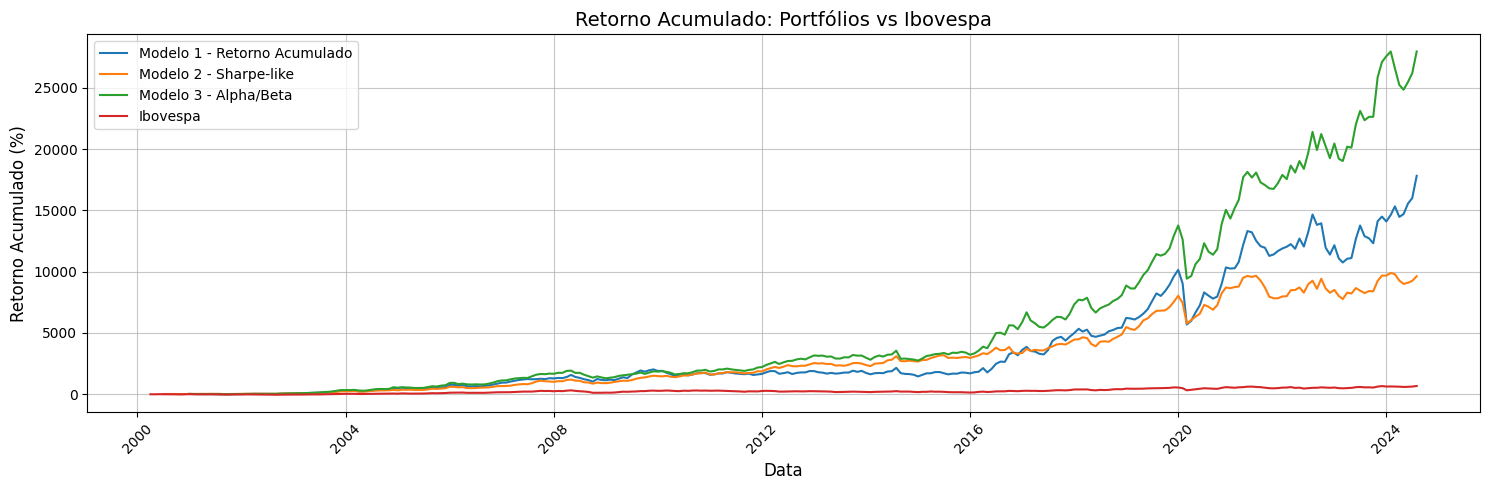

In [ ]:
# Garantir que os índices estão em datetime
for df in [Port1_acc, Port2_acc, Port3_acc]:
    df.index = pd.to_datetime(df.index)

# Separar as séries individuais
Ref = Port1_acc['Referencia'].copy()
Port1 = Port1_acc['Port1'].copy()
Port2 = Port2_acc['Port2'].copy()
Port3 = Port3_acc['Port3'].copy()

# Verificar e remover valores infinitos ou ausentes
for serie in [Port1, Port2, Port3, Ref]:
    serie.replace([np.inf, -np.inf], np.nan, inplace=True)

Port1.dropna(inplace=True)
Port2.dropna(inplace=True)
Port3.dropna(inplace=True)
Ref.dropna(inplace=True)

# Criar o gráfico com o estilo OO do matplotlib
fig, ax = plt.subplots(figsize=(15, 5))

# Plotar as séries
ax.plot(Port1.index, Port1 * 100, label='Modelo 1 - Retorno Acumulado')
ax.plot(Port2.index, Port2 * 100, label='Modelo 2 - Sharpe-like')
ax.plot(Port3.index, Port3 * 100, label='Modelo 3 - Alpha/Beta')
ax.plot(Ref.index, Ref * 100, label='Ibovespa')

# Ajustes visuais
ax.set_title('Retorno Acumulado: Portfólios vs Ibovespa', fontsize=14)
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Retorno Acumulado (%)', fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.7)
ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

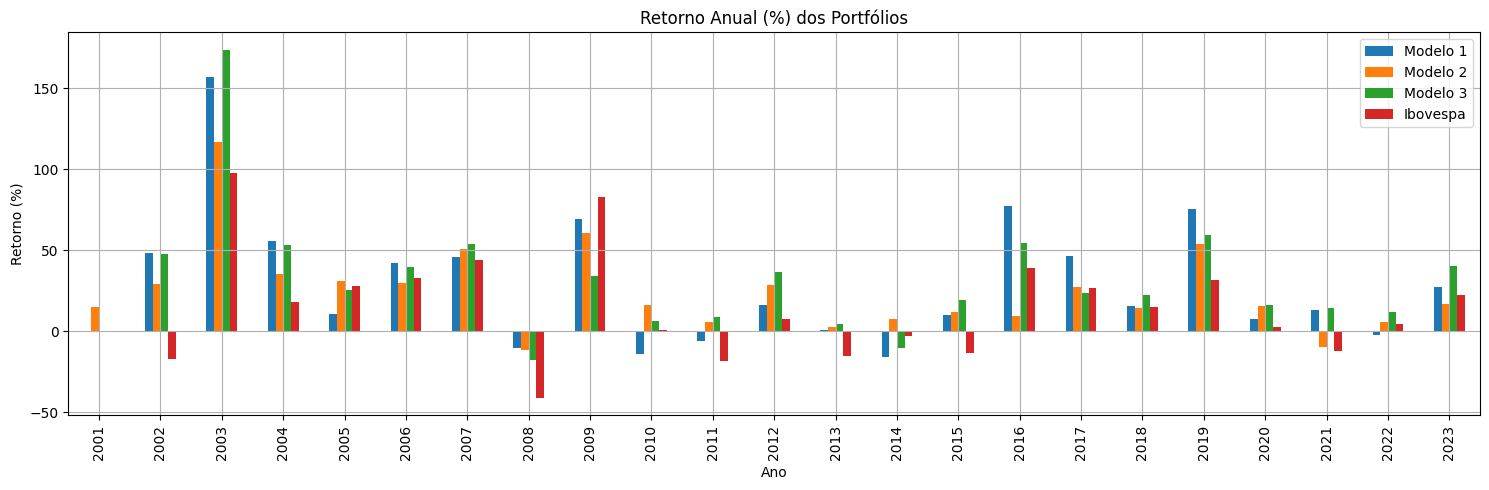

In [ ]:
# Calcular retorno anual para cada portfólio
Port1_12_temp = ((1 + Port1_acc) / (1 + Port1_acc.shift(12)) - 1) * 100
Port2_12_temp = ((1 + Port2_acc) / (1 + Port2_acc.shift(12)) - 1) * 100
Port3_12_temp = ((1 + Port3_acc) / (1 + Port3_acc.shift(12)) - 1) * 100

# Selecionar datas de fim de ano
datas_anuais = pd.date_range(start=start, end=end, freq='YE').strftime('%b-%Y')

# Obter os valores de retorno anual nas datas específicas
Port1_12m = Port1_12_temp.loc[Port1_12_temp.index.strftime('%b-%Y').isin(datas_anuais)].dropna()
Port2_12m = Port2_12_temp.loc[Port2_12_temp.index.strftime('%b-%Y').isin(datas_anuais)].dropna()
Port3_12m = Port3_12_temp.loc[Port3_12_temp.index.strftime('%b-%Y').isin(datas_anuais)].dropna()

# Criar DataFrame combinado para plotar
retornos_anuais = pd.DataFrame({
    'Modelo 1': Port1_12m['Port1'],
    'Modelo 2': Port2_12m['Port2'],
    'Modelo 3': Port3_12m['Port3'],
    'Ibovespa': Port1_12m['Referencia']
})

# Ajustar índice para mostrar os anos no gráfico
retornos_anuais.index = retornos_anuais.index.strftime('%Y')

# Plotar gráfico de barras
retornos_anuais.plot.bar(figsize=(15, 5), grid=True)
plt.title('Retorno Anual (%) dos Portfólios')
plt.ylabel('Retorno (%)')
plt.xlabel('Ano')
plt.tight_layout()
plt.show()

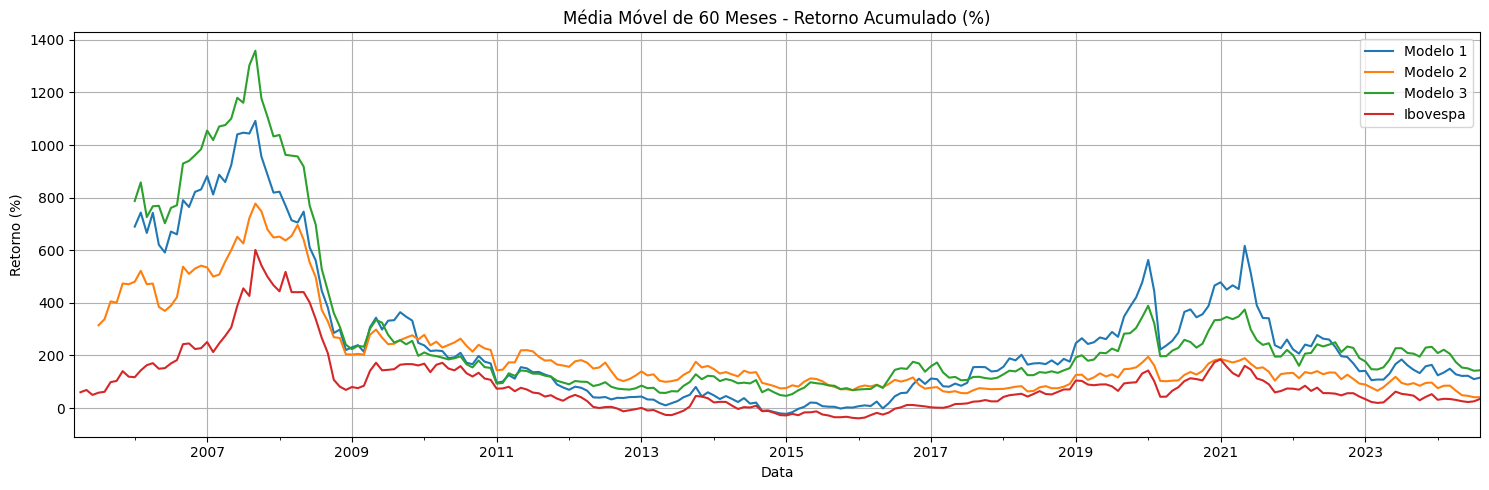

In [ ]:
# Parâmetro da média móvel
med_movel = 60

# Calcular médias móveis para cada portfólio
Port1_med_movel = ((1 + Port1_acc) / (1 + Port1_acc.shift(med_movel)) - 1) * 100
Port2_med_movel = ((1 + Port2_acc) / (1 + Port2_acc.shift(med_movel)) - 1) * 100
Port3_med_movel = ((1 + Port3_acc) / (1 + Port3_acc.shift(med_movel)) - 1) * 100

# Combinar em DataFrame para plotar juntos
med_movel_df = pd.DataFrame({
    'Modelo 1': Port1_med_movel['Port1'],
    'Modelo 2': Port2_med_movel['Port2'],
    'Modelo 3': Port3_med_movel['Port3'],
    'Ibovespa': Port1_med_movel['Referencia']
})

# Plotar a partir do ponto onde todos têm dados válidos
med_movel_df.iloc[med_movel - 1:].plot(figsize=(15, 5), grid=True)
plt.title(f'Média Móvel de {med_movel} Meses - Retorno Acumulado (%)')
plt.ylabel('Retorno (%)')
plt.xlabel('Data')
plt.tight_layout()
plt.show()

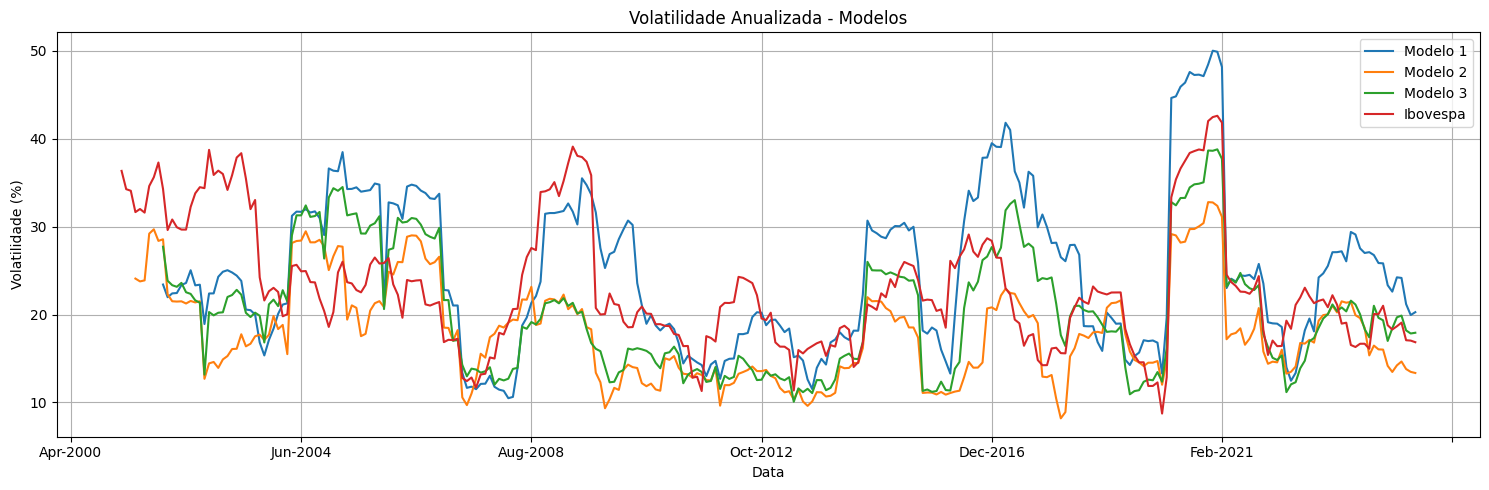

In [ ]:
# Calcular volatilidade anualizada (rolling 12 meses)
Port1_vol_anual = (1 + Port1_ret_men).rolling(12).std() * (12 ** 0.5) * 100
Port2_vol_anual = (1 + Port2_ret_men).rolling(12).std() * (12 ** 0.5) * 100
Port3_vol_anual = (1 + Port3_ret_men).rolling(12).std() * (12 ** 0.5) * 100

# Combinar em um único DataFrame
vol_anual_df = pd.DataFrame({
    'Modelo 1': Port1_vol_anual['Port1'],
    'Modelo 2': Port2_vol_anual['Port2'],
    'Modelo 3': Port3_vol_anual['Port3'],
    'Ibovespa': Port1_vol_anual['Referencia']
})

# Plotar tudo junto
vol_anual_df.plot(figsize=(15, 5), grid=True)
plt.title('Volatilidade Anualizada - Modelos')
plt.ylabel('Volatilidade (%)')
plt.xlabel('Data')
plt.tight_layout()
plt.show()

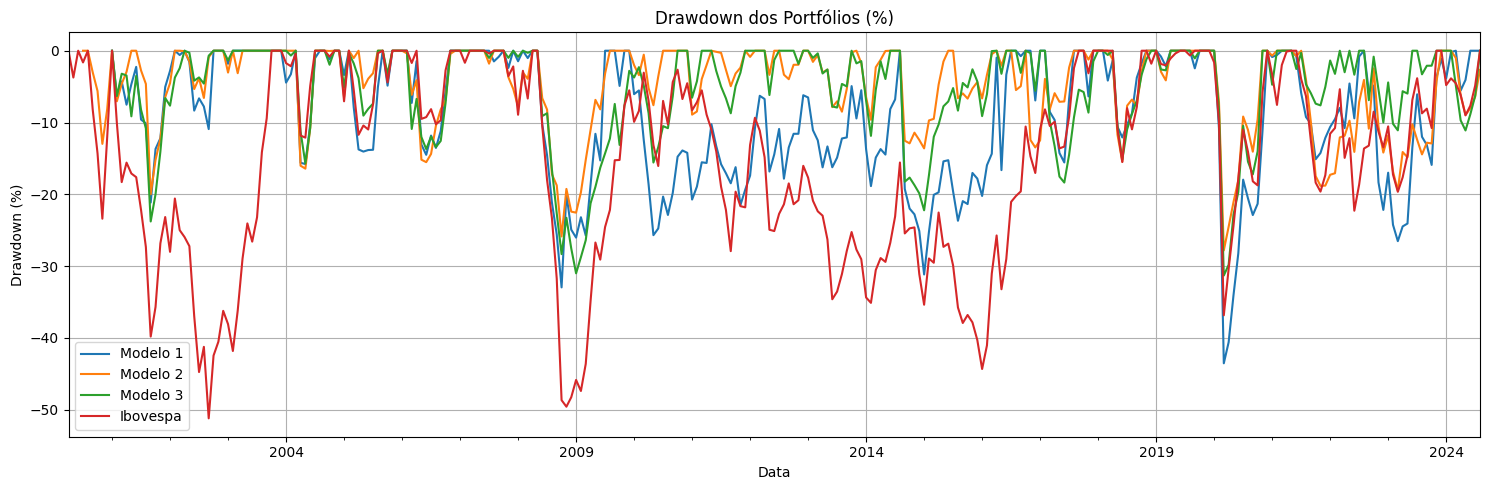

In [ ]:
# Calcular o drawdown para cada portfólio
Port1_acc_max = Port1_acc.cummax()
Port1_drawdown = (((1 + Port1_acc) / (1 + Port1_acc_max)) - 1) * 100

Port2_acc_max = Port2_acc.cummax()
Port2_drawdown = (((1 + Port2_acc) / (1 + Port2_acc_max)) - 1) * 100

Port3_acc_max = Port3_acc.cummax()
Port3_drawdown = (((1 + Port3_acc) / (1 + Port3_acc_max)) - 1) * 100

# Criar DataFrame com os drawdowns
df_drawdown = pd.DataFrame({
    'Modelo 1': Port1_drawdown['Port1'],
    'Modelo 2': Port2_drawdown['Port2'],
    'Modelo 3': Port3_drawdown['Port3'],
    'Ibovespa': Port1_drawdown['Referencia']
})

# Plotar os três drawdowns no mesmo gráfico
df_drawdown.plot(figsize=(15, 5), grid=True)
plt.title('Drawdown dos Portfólios (%)')
plt.ylabel('Drawdown (%)')
plt.xlabel('Data')
plt.tight_layout()
plt.show()

Como pode ser observado, o modelo 3 se destaca perante os demais durante a maior parte do tempo, apresentando o maior retorno anual percentual durante boa parte da série, volatilidade e drowdown bastante moderados e boa performance nos demais comparativos. Enquanto o portifólio 2 se destaca por ser mais estável, devido a sua volatilidade e drowdown serem bastante baixos, em contraste ao seu menor retorno percentual acumulado, apresentando performance inferior aos demais a partir de 2016, mas ainda superando o Ibovespa.